In [69]:
%matplotlib inline
py.init_notebook_mode(connected=True)

In [70]:
import pandas as pd
import numpy as np
from matplotlib import pyplot
import plotly.offline as py
import plotly.graph_objs as go
import datetime as dt
import seaborn as sns
import sys, os
import matplotlib.dates as mdates
import matplotlib.cbook as cbook
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Activation, Dense
from keras.layers import LSTM
from keras.layers import Dropout
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from math import sqrt

In [23]:
# load data

bitcoin = pd.read_csv('crypto_data/bitcoin_price.csv')
bitcoin_cash = pd.read_csv('crypto_data/bitcoin_cash_price.csv')
bitconnect = pd.read_csv('crypto_data/bitconnect_price.csv')
dash = pd.read_csv('crypto_data/dash_price.csv')
ethereum = pd.read_csv('crypto_data/ethereum_price.csv')
ethereum_classic = pd.read_csv('crypto_data/ethereum_classic_price.csv')
iota = pd.read_csv('crypto_data/iota_price.csv')
litecoin = pd.read_csv('crypto_data/litecoin_price.csv')
monero = pd.read_csv('crypto_data/monero_price.csv')
nem = pd.read_csv('crypto_data/nem_price.csv')
neo = pd.read_csv('crypto_data/neo_price.csv')
numeraire = pd.read_csv('crypto_data/numeraire_price.csv')
omisego = pd.read_csv('crypto_data/omisego_price.csv')
qtum = pd.read_csv('crypto_data/qtum_price.csv')
ripple = pd.read_csv('crypto_data/ripple_price.csv')
stratis = pd.read_csv('crypto_data/stratis_price.csv')
waves = pd.read_csv('crypto_data/waves_price.csv')

__split = '2017-09-01'
__window = 10

In [24]:
# remove commas, set unavalable data to 0, convert to float
bitcoin['Volume'] = bitcoin['Volume'].apply(lambda n: n.split()[0].replace(',', ''))
bitcoin.loc[bitcoin['Volume'] == "-",'Volume'] = 0
bitcoin['Volume'] = bitcoin['Volume'].astype('int64')

In [25]:
# remove commas, convert to float
bitcoin['Market Cap'] = bitcoin['Market Cap'].apply(lambda n: n.split()[0].replace(',', ''))
bitcoin['Market Cap'] = bitcoin['Market Cap'].astype('int64')

In [26]:
# convert date
bitcoin['Date'] = pd.to_datetime(bitcoin['Date'])
# bitcoin.sort_values('Date', inplace=True)
# btc_temp = bitcoin
# btc_temp.set_index('Date', inplace=True)

In [27]:
bitcoin.head()

,Date,Open,High,Low,Close,Volume,Market Cap
0,2018-02-20,11231.8,11958.5,11231.80,11403.7,9926540000,189536000000
1,2018-02-19,10552.6,11273.8,10513.20,11225.3,7652090000,178055000000
2,2018-02-18,11123.4,11349.8,10326.00,10551.8,8744010000,187663000000
3,2018-02-17,10207.5,11139.5,10149.40,11112.7,8660880000,172191000000
4,2018-02-16,10135.7,10324.1,9824.82,10233.9,7296160000,170960000000


In [28]:
# bitcoin.sort_values('Date', inplace=True)
bitcoin.set_index('Date', inplace=True)

In [29]:
bitcoin.head()

,Open,High,Low,Close,Volume,Market Cap
Date,,,,,,
2018-02-20,11231.8,11958.5,11231.80,11403.7,9926540000,189536000000
2018-02-19,10552.6,11273.8,10513.20,11225.3,7652090000,178055000000
2018-02-18,11123.4,11349.8,10326.00,10551.8,8744010000,187663000000
2018-02-17,10207.5,11139.5,10149.40,11112.7,8660880000,172191000000
2018-02-16,10135.7,10324.1,9824.82,10233.9,7296160000,170960000000


In [30]:
# add new relevant features
bitcoin['Volatility'] = (bitcoin['High'] - bitcoin['Low']) / bitcoin['Open']
bitcoin['Close_High_Gap'] = bitcoin['Close'] - bitcoin['High']

In [31]:
bitcoin.head()

,Open,High,Low,Close,Volume,Market Cap,Volatility,Close_High_Gap
Date,,,,,,,,
2018-02-20,11231.8,11958.5,11231.80,11403.7,9926540000,189536000000,0.064700,-554.8
2018-02-19,10552.6,11273.8,10513.20,11225.3,7652090000,178055000000,0.072077,-48.5
2018-02-18,11123.4,11349.8,10326.00,10551.8,8744010000,187663000000,0.092040,-798.0
2018-02-17,10207.5,11139.5,10149.40,11112.7,8660880000,172191000000,0.096997,-26.8
2018-02-16,10135.7,10324.1,9824.82,10233.9,7296160000,170960000000,0.049260,-90.2


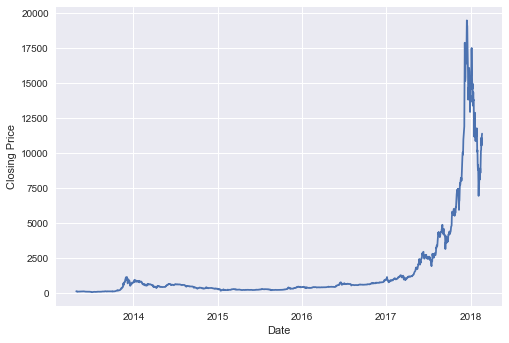

In [32]:
fig, ax = plt.subplots()
ax.set_ylabel('Closing Price')
ax.set_xlabel('Date')
ax.plot(bitcoin.index, bitcoin['Close'])
plt.show()

In [33]:
# normalize
bitcoin = bitcoin / bitcoin.iloc[0] - 1

In [34]:
bitcoin.head(20)

,Open,High,Low,Close,Volume,Market Cap,Volatility,Close_High_Gap
Date,,,,,,,,
2018-02-20,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2018-02-19,-0.060471,-0.057256,-0.063979,-0.015644,-0.229128,-0.060574,0.114015,-0.912581
2018-02-18,-0.009651,-0.050901,-0.080646,-0.074704,-0.119128,-0.009882,0.422564,0.438356
2018-02-17,-0.091196,-0.068487,-0.096369,-0.025518,-0.127503,-0.091513,0.499180,-0.951694
2018-02-16,-0.097589,-0.136673,-0.125268,-0.102581,-0.264985,-0.098008,-0.238650,-0.837419
2018-02-15,-0.155227,-0.144140,-0.163484,-0.108500,-0.087039,-0.155701,0.367038,-0.876712
2018-02-14,-0.234324,-0.204036,-0.234324,-0.167408,-0.203164,-0.234852,0.650957,-0.956903
2018-02-13,-0.205228,-0.250870,-0.247190,-0.246007,-0.426112,-0.205871,-0.128992,-0.350829
2018-02-12,-0.275145,-0.248575,-0.275145,-0.217222,-0.369726,-0.275821,0.603201,-0.893025


In [35]:
train, test = bitcoin[bitcoin.index < __split], bitcoin[bitcoin.index >= __split]

In [36]:
train_pt = []
test_pt = []

for elem in range(len(train) - __window):
    train_temp = train[elem : (elem + __window)].copy()
    train_temp = train_temp / train_temp.iloc[0] - 1
    train_pt.append(train_temp)
    
train_y_pts = (train['Close'][__window:].values / train['Close'][: - __window].values) - 1
train_pt = [np.array(elem) for elem in train_pt]
train_pt = np.array(train_pt)

for elem in range(len(test) - __window):
    test_temp = test[elem : (elem + __window)].copy()
    test_temp = test_temp / test_temp.iloc[0] - 1
    test_pt.append(test_temp)
    
test_y_pts = (test['Close'][__window:].values / test['Close'][: - __window].values) - 1
test_pt = [np.array(elem) for elem in test_pt]
test_pt = np.array(test_pt)

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:18: RuntimeWarning: divide by zero encountered in true_divide


In [37]:
train.head()

,Open,High,Low,Close,Volume,Market Cap,Volatility,Close_High_Gap
Date,,,,,,,,
2017-08-31,-0.594403,-0.603960,-0.594954,-0.587556,-0.804068,-0.602596,-0.366747,-0.941132
2017-08-30,-0.593087,-0.613119,-0.601897,-0.599665,-0.804781,-0.601360,-0.475454,-0.889654
2017-08-29,-0.609216,-0.613189,-0.612517,-0.598462,-0.749552,-0.617203,-0.036738,-0.915898
2017-08-28,-0.609640,-0.631732,-0.623868,-0.615681,-0.802617,-0.617656,-0.367974,-0.961662
2017-08-27,-0.613143,-0.630674,-0.615619,-0.615662,-0.845116,-0.621132,-0.646781,-0.939239


In [38]:
# check which features have low or negative importance
reg_X = train
reg_X.drop('Close', axis=1)
reg_y = train['Close']

regressor = RandomForestRegressor()
regressor.fit(reg_X, reg_y)
regressor.feature_importances_


array([1.58673277e-01, 9.16015602e-02, 1.89054496e-01, 4.83773627e-01,
       3.37225998e-05, 7.68330905e-02, 1.92146930e-05, 1.10114433e-05])

In [39]:
# get low importance indices
indices = np.argsort(regressor.feature_importances_)[::-1]
indices

array([3, 2, 0, 1, 5, 4, 6, 7])

In [ ]:
# volatility, close_high_gap and volume have the lowest importance

In [40]:
bitcoin_model = Sequential()
bitcoin_model.add(LSTM(20, input_shape=(train_pt.shape[1], train_pt.shape[2])))
bitcoin_model.add(Dropout(0.25))
bitcoin_model.add(Dense(units=1))
bitcoin_model.add(Activation("linear"))
bitcoin_model.compile(loss="mae", optimizer="adam")
train_res = (train['Close'][__window : ].values / train['Close'][ : - __window].values) - 1
bitcoin_hist = bitcoin_model.fit(train_pt, train_res, epochs = 30, batch_size = 1, verbose = 1, shuffle = True)

Epoch 1/30
1577/1577 [==============================] - 33s 21ms/step - loss: 0.0486
Epoch 2/30
1577/1577 [==============================] - 31s 20ms/step - loss: 0.0177
Epoch 3/30
1577/1577 [==============================] - 32s 20ms/step - loss: 0.0107
Epoch 4/30
1577/1577 [==============================] - 31s 20ms/step - loss: 0.0067
Epoch 5/30
1577/1577 [==============================] - 19s 12ms/step - loss: 0.0053
Epoch 6/30
1577/1577 [==============================] - 17s 10ms/step - loss: 0.0045
Epoch 7/30
1577/1577 [==============================] - 17s 11ms/step - loss: 0.0042
Epoch 8/30
1577/1577 [==============================] - 18s 11ms/step - loss: 0.0039
Epoch 9/30
1577/1577 [==============================] - 17s 10ms/step - loss: 0.0037
Epoch 10/30
1577/1577 [==============================] - 15s 10ms/step - loss: 0.0036
Epoch 11/30
1577/1577 [==============================] - 15s 10ms/step - loss: 0.0035
Epoch 12/30
1577/1577 [==============================] - 16s 10

In [ ]:
# remove features with low importance
train, test = bitcoin[bitcoin.index < __split], bitcoin[bitcoin.index >= __split]
train.drop(['Volume', 'Volatility', 'Close_High_Gap'], axis=1, inplace=True)
test.drop(['Volume', 'Volatility', 'Close_High_Gap'], axis=1, inplace=True)

In [44]:
train_pt = []
test_pt = []

for elem in range(len(train) - __window):
    train_temp = train[elem : (elem + __window)].copy()
    train_temp = train_temp / train_temp.iloc[0] - 1
    train_pt.append(train_temp)
    
train_y_pts = (train['Close'][__window:].values / train['Close'][: - __window].values) - 1
train_pt = [np.array(elem) for elem in train_pt]
train_pt = np.array(train_pt)

for elem in range(len(test) - __window):
    test_temp = test[elem : (elem + __window)].copy()
    test_temp = test_temp / test_temp.iloc[0] - 1
    test_pt.append(test_temp)
    
test_y_pts = (test['Close'][__window:].values / test['Close'][: - __window].values) - 1
test_pt = [np.array(elem) for elem in test_pt]
test_pt = np.array(test_pt)

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:18: RuntimeWarning: divide by zero encountered in true_divide


In [45]:
# retrain with same model but removed features
bitcoin_model_lf = Sequential()
bitcoin_model_lf.add(LSTM(20, input_shape=(train_pt.shape[1], train_pt.shape[2])))
bitcoin_model_lf.add(Dropout(0.25))
bitcoin_model_lf.add(Dense(units=1))
bitcoin_model_lf.add(Activation("linear"))
bitcoin_model_lf.compile(loss="mae", optimizer="adam")
train_res = (train['Close'][__window : ].values / train['Close'][ : - __window].values) - 1
bitcoin_hist_lf = bitcoin_model_lf.fit(train_pt, train_res, epochs = 30, batch_size = 1, verbose = 1, shuffle = True)

Epoch 1/30
1577/1577 [==============================] - 17s 11ms/step - loss: 0.0039
Epoch 2/30
1577/1577 [==============================] - 16s 10ms/step - loss: 0.0031
Epoch 3/30
1577/1577 [==============================] - 16s 10ms/step - loss: 0.0028
Epoch 4/30
1577/1577 [==============================] - 17s 11ms/step - loss: 0.0026
Epoch 5/30
1577/1577 [==============================] - 16s 10ms/step - loss: 0.0024
Epoch 6/30
1577/1577 [==============================] - 16s 10ms/step - loss: 0.0023
Epoch 7/30
1577/1577 [==============================] - 17s 11ms/step - loss: 0.0022
Epoch 8/30
1577/1577 [==============================] - 17s 11ms/step - loss: 0.0022
Epoch 9/30
1577/1577 [==============================] - 17s 11ms/step - loss: 0.0020
Epoch 10/30
1577/1577 [==============================] - 17s 11ms/step - loss: 0.0020
Epoch 11/30
1577/1577 [==============================] - 17s 11ms/step - loss: 0.0018
Epoch 12/30
1577/1577 [==============================] - 17s 10

In [46]:
# retrain with same model but removed features, changed the following 
# different dropout, loss, hidden layers, num of epochs, batch

bitcoin_model_ch = Sequential()
bitcoin_model_ch.add(LSTM(200, return_sequences=True, input_shape=(train_pt.shape[1], train_pt.shape[2])))
bitcoin_model_ch.add(Dropout(0.2, noise_shape=None, seed=None))
bitcoin_model_ch.add(LSTM(200))
bitcoin_model_ch.add(Dropout(0.2, noise_shape=None, seed=None))
bitcoin_model_ch.add(Dense(1))
bitcoin_model_ch.add(Activation("linear"))
bitcoin_model_ch.compile(loss="mean_squared_error", optimizer="adam")
train_res = (train['Close'][__window : ].values / train['Close'][ : - __window].values) - 1
bitcoin_hist = bitcoin_model_ch.fit(train_pt, train_res, epochs = 50, batch_size = 3, verbose = 1, shuffle = True)

Epoch 1/50
1577/1577 [==============================] - 13s 8ms/step - loss: 7.7346e-05
Epoch 2/50
1577/1577 [==============================] - 12s 7ms/step - loss: 4.5872e-05
Epoch 3/50
1577/1577 [==============================] - 12s 8ms/step - loss: 4.2412e-05
Epoch 4/50
1577/1577 [==============================] - 13s 8ms/step - loss: 3.5066e-05
Epoch 5/50
1577/1577 [==============================] - 13s 8ms/step - loss: 3.7246e-05
Epoch 6/50
1577/1577 [==============================] - 13s 8ms/step - loss: 2.4617e-05
Epoch 7/50
1577/1577 [==============================] - 13s 8ms/step - loss: 2.8433e-05
Epoch 8/50
1577/1577 [==============================] - 13s 8ms/step - loss: 2.6386e-05
Epoch 9/50
1577/1577 [==============================] - 13s 8ms/step - loss: 2.6065e-05
Epoch 10/50
1577/1577 [==============================] - 13s 8ms/step - loss: 4.1676e-05
Epoch 11/50
1577/1577 [==============================] - 13s 8ms/step - loss: 2.6485e-05
Epoch 12/50
1577/1577 [=======

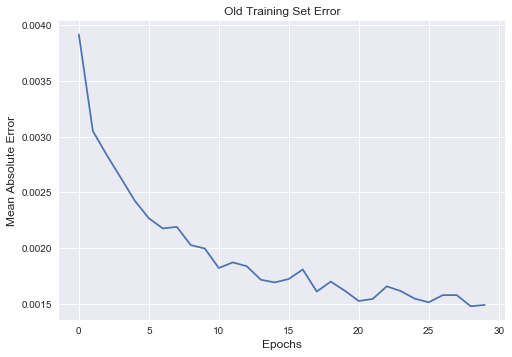

In [47]:
# old training set error
fig, ax = plt.subplots()
ax.plot(bitcoin_hist_lf.epoch, bitcoin_hist_lf.history['loss'])
ax.set_title('Old Training Set Error')
ax.set_ylabel('Mean Absolute Error',fontsize=12)
ax.set_xlabel('Epochs',fontsize=12)
plt.show()

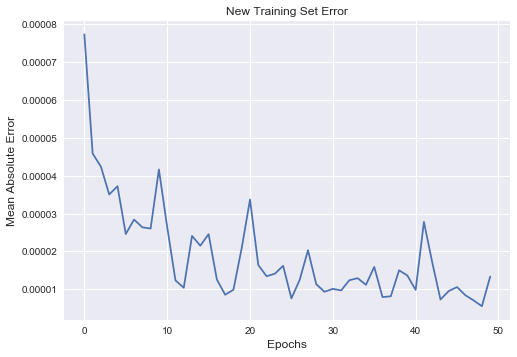

In [48]:
# new training set error
fig, ax = plt.subplots()
ax.plot(bitcoin_hist.epoch, bitcoin_hist.history['loss'])
ax.set_title('New Training Set Error')
ax.set_ylabel('Mean Absolute Error',fontsize=12)
ax.set_xlabel('Epochs',fontsize=12)
plt.show()

In [62]:
def drawing(true, predict):
    RMSE = sqrt(mean_squared_error(true['Close'][__window+1:], predict[0][1:]))
    print('RMSE: %.3f' % RMSE)
    
    model = go.Scatter(x = np.arange(0, len(predict), 1), y = predict[0][0:], mode = 'lines', name = 'Price Prediction', hoverlabel = dict(namelength=-1), line = dict(color=('rgb(0, 191, 255)'), width=2))
    real = go.Scatter(x = np.arange(0, len(true), 1), y = true['Close'][__window:], mode = 'lines', name = 'Actual Price', line = dict(color=('rgb(205, 92, 92)'), width=2))
    data = [model, real]
    layout = dict(title = 'Actual vs Predicted', xaxis = dict(title = 'Day'), yaxis = dict(title = 'Price'))
    fig = dict(data=data, layout=layout)
    py.iplot(fig)

In [51]:
train['Close'][__window:]

# predictions 1 day
predictions = ((np.transpose(bitcoin_model_ch.predict(train_pt)) + 1) * train['Close'].values[: - __window])
predct_df = pd.DataFrame(data = predictions[0,0:])

In [52]:
predct_df

,0
0,-0.632095
1,-0.628647
2,-0.620178
3,-0.628811
4,-0.617880
5,-0.611238
6,-0.627043
7,-0.620657
8,-0.642091
9,-0.651356


In [56]:
test['Close'][__window:]

# predictions 1 day
predictions_test = ((np.transpose(bitcoin_model.predict(test_pt)) + 1) * test['Close'].values[: - __window])
pred_df = pd.DataFrame(data = predictions_test[0,0:])
pred_df[0].fillna(0,inplace=True)

In [57]:
pred_df

,0
0,0.000000
1,-0.022680
2,-0.107770
3,-0.036655
4,-0.142375
5,-0.160526
6,-0.227793
7,-0.220451
8,-0.193230
9,-0.268628


In [71]:
# train prediciton plot
drawing(train, predct_df)

RMSE: 0.004


In [72]:
# test prediction plot
drawing(test, pred_df)

RMSE: 0.186
